# Capstone: West Nile Virus
## Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.pipeline import Pipeline, make_pipeline

from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display
from IPython.display import Image

##### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [2]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


We make a note here of the baseline to be bettered through modelling:

In [3]:
print('Baseline = {}'.format(train.WnvPresent.value_counts(normalize=True).max()))
train.WnvPresent.value_counts()

# we can see clearly the problem: only 5% of those traps inspected carried Wnv, can we improve on this?
# we also see a class imbalance here that will need to be resolved before modelling

Baseline = 0.9475537787930707


0    9955
1     551
Name: WnvPresent, dtype: int64

In [4]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


##### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [5]:
weather = pd.read_csv('./datasets/weather.csv')
# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))

# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head(1)

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2


In [6]:
# save to csv for import into Tableau
weather.to_csv(r'./datasets/weather_map.csv')

##### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [7]:
spray = pd.read_csv('./datasets/spray.csv')
# Make Date into datetime object, and index
spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')
spray.set_index('Date', inplace=True, drop=True)
spray.drop(columns='Time', inplace=True)
spray.head(1)

,Latitude,Longitude
Date,,
2011-08-29,42.391623,-88.089163


## EDA

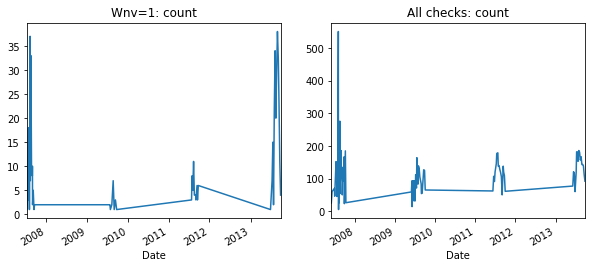

In [8]:
# strong seasonal effects according to WnvPresent timeline of incidence:
# interestingly 2007 and 2013 had far higher incidences than the intervening years.
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
train[train['WnvPresent']==1]['WnvPresent'].groupby('Date').count().plot(ax=ax[0], title='Wnv=1: count')
train['WnvPresent'].groupby('Date').count().plot(ax=ax[1], title='All checks: count');

# comparing this plot to the one above, we see there were fewer tests overall in the intervening years, and more
# tests in 2013 coupled with higher rate of positives, why?
    # Was Chicago starting to predict better the WNV's whereabouts in 2013?
    # Did weather mean there were more mosquitos and therefore more WNV in 2007 and 2013 vs. other times?

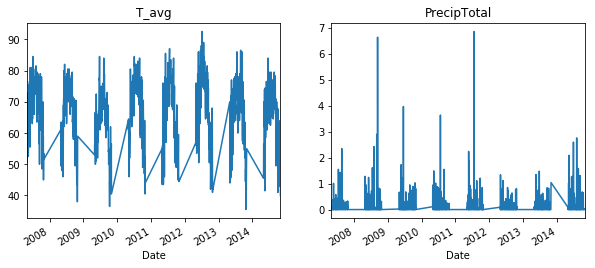

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
pd.to_numeric(weather[(weather['Station']==1)].Tavg).plot(ax=ax[0], title='T_avg')
pd.to_numeric(weather[(weather['Station']==1)].PrecipTotal).plot(ax=ax[1], title='PrecipTotal');

# Specific daily temperatures and precipitations is a good way to predict for specific days' Wnv, I will merge
# with train data

In [11]:
# Reformatting weather data into flattened version for merging with train data, and selecting only
# relevant data:
weather_station_1 = weather[weather['Station']==1]
weather_station_2 = weather[weather['Station']==2]

weather_df = weather_station_1.merge(weather_station_2,
                                     how='inner',
                                     on='Date',
                                     suffixes=('_station_1','_station_2'))
weather_df.head(1)

,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6


In [12]:
# Merging weather data onto train data:
train_df = train.merge(weather_df, how='left', on='Date', suffixes=('',''))
train_df.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1,41.995,-87.933,88,60,74.0,10,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18,6.5,2,41.786,-87.752,88,65,76.5,M,59,66,0,12,-,-,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4


In [29]:
train_trap_plot = train.groupby(['Date','Trap','Latitude','Longitude']).agg({'WnvPresent':'sum',
                                                                             'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                                                 ascending=False)
train_trap_plot.to_csv(r'./datasets/train_map.csv')

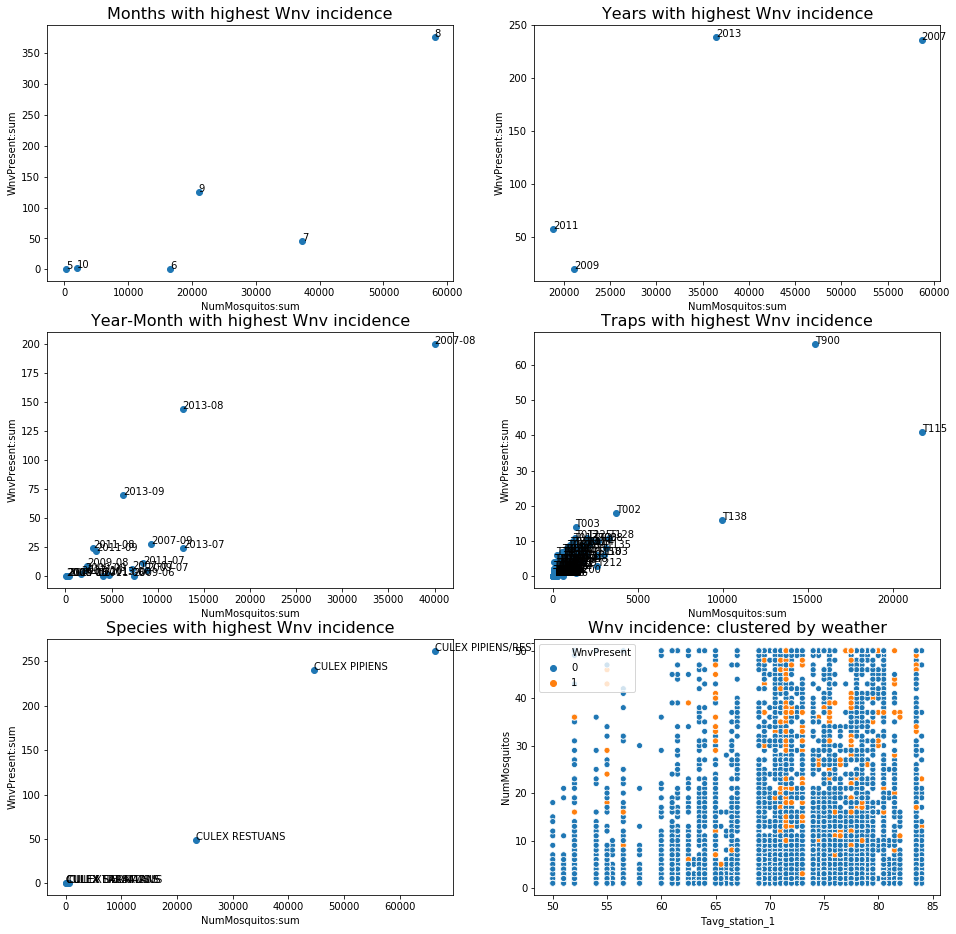

In [13]:
# When (ie, which summer month / which year) had the highest incidence of Wnv and NumMosquitos?
# And where (ie, which trap) had the highest incidence of Wnv and NumMosquitos?

train_month_grp = train.groupby(train.index.month).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)
train_year_grp = train.groupby(train.index.year).agg({'WnvPresent':'sum',
                                                      'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                          ascending=False)
train_monthyear_grp = train.groupby(train.index.to_period('M')).agg({'WnvPresent':'sum',
                                                                     'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                                         ascending=False)
train_trap_grp = train.groupby('Trap').agg({'WnvPresent':'sum',
                                            'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                ascending=False)
train_species_grp = train.groupby('Species').agg({'WnvPresent':'sum',
                                                  'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                      ascending=False)
# Scatter-plot both sets of data:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
ax[0,0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent']);
for i, xi in enumerate(train_month_grp.index):
    ax[0,0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]))
ax[0,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,0].set_title('Months with highest Wnv incidence', fontsize=16)

ax[0,1].scatter(train_year_grp['NumMosquitos'], train_year_grp['WnvPresent']);
for i, xi in enumerate(train_year_grp.index):
    ax[0,1].annotate(xi, (train_year_grp.iloc[i,1], train_year_grp.iloc[i,0]))
ax[0,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,1].set_title('Years with highest Wnv incidence', fontsize=16)

ax[1,0].scatter(train_monthyear_grp['NumMosquitos'], train_monthyear_grp['WnvPresent']);
for i, xi in enumerate(train_monthyear_grp.index):
    ax[1,0].annotate(xi, (train_monthyear_grp.iloc[i,1], train_monthyear_grp.iloc[i,0]))
ax[1,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,0].set_title('Year-Month with highest Wnv incidence', fontsize=16)

ax[1,1].scatter(train_trap_grp['NumMosquitos'], train_trap_grp['WnvPresent']);
for i, xi in enumerate(train_trap_grp.index):
    ax[1,1].annotate(xi, (train_trap_grp.iloc[i,1], train_trap_grp.iloc[i,0]))
ax[1,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,1].set_title('Traps with highest Wnv incidence', fontsize=16)

ax[2,0].scatter(train_species_grp['NumMosquitos'], train_species_grp['WnvPresent']);
for i, xi in enumerate(train_species_grp.index):
    ax[2,0].annotate(xi, (train_species_grp.iloc[i,1], train_species_grp.iloc[i,0]))
ax[2,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[2,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[2,0].set_title('Species with highest Wnv incidence', fontsize=16)

sns.scatterplot(train_df['Tavg_station_1'], train_df['NumMosquitos'], hue=train_df['WnvPresent'], ax=ax[2,1]);
ax[2,1].set_xlabel('Tavg_station_1', fontsize=10)
ax[2,1].set_ylabel('NumMosquitos', fontsize=10)
ax[2,1].set_title('Wnv incidence: clustered by weather', fontsize=16)

plt.show();

# Clear to see that both Wnv and NumMosquitos was highest in certain Traps, years, and months.

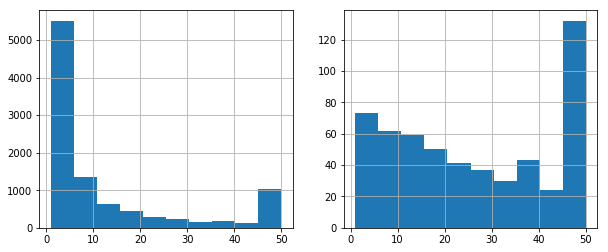

In [14]:
# Plotting histograms for NumMosquitos for each of Wnv=0 and Wnv=1 cases illustrates NumMosquitos
# could be a predictor of Wnv if we deal with the class imbalance:
fig, ax = plt.subplots(figsize=(10,4), ncols=2)
train_df[train_df['WnvPresent']==0]['NumMosquitos'].hist(ax=ax[0])
train_df[train_df['WnvPresent']==1]['NumMosquitos'].hist(ax=ax[1]);

In [15]:
# ADASYN to deal with class imbalance:
ad = ADASYN()

# Decision Tree classifier:
dt = DecisionTreeClassifier(max_depth=4, random_state=1)

# Simple pipeline set-up - in order to ensure that cross-val scoring has resampling applied to training folds
pipeline = Pipeline([('ad', ad), ('dt', dt)])

# Set up X, y:
y, X = train_df['WnvPresent'], train_df[['Tavg_station_1','PrecipTotal_station_1']]

# Fit pipeline:
pipeline.fit(X, y)

# Scoring pipeline:
print('Training score:',pipeline.score(X, y))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
print('CV KF score:',cross_val_score(pipeline, X, y, cv=kf).mean())
ts = TimeSeriesSplit(n_splits=5)
print('CV TS score:',cross_val_score(pipeline, X, y, cv=ts).mean())

predictions = pipeline.predict(X)
print(' ')
print('Confusion Matrix:')
print(confusion_matrix(y, predictions, labels=[0,1]))
print(' ')
print('Classification Report:')
print(classification_report(y, predictions))

Training score: 0.6841804683038264
CV KF score: 0.6715197013247736
CV TS score: 0.597829811536265
 
Confusion Matrix:
[[6838 3117]
 [ 201  350]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.80      9955
           1       0.10      0.64      0.17       551

    accuracy                           0.68     10506
   macro avg       0.54      0.66      0.49     10506
weighted avg       0.93      0.68      0.77     10506



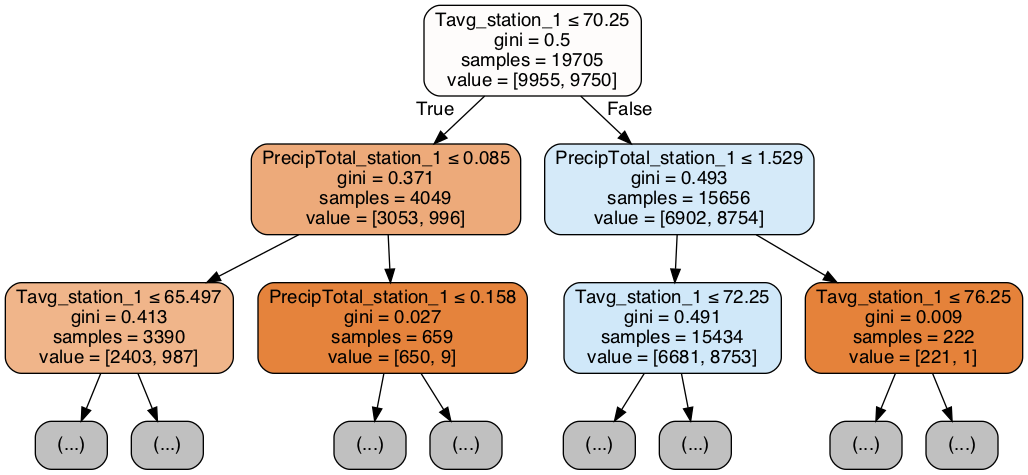

In [16]:
# Plot the Decision Tree:
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                max_depth=2,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=['Tavg_station_1','PrecipTotal_station_1']
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

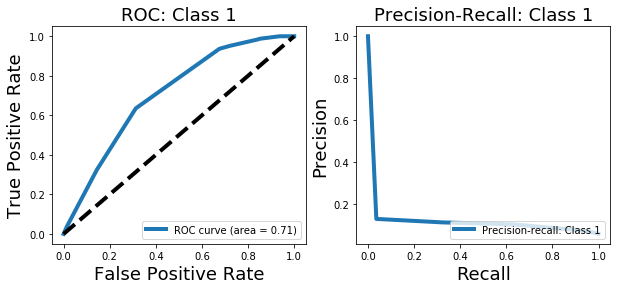

In [17]:
# Create predicted probabilities dataframe
y_pp = pd.DataFrame(pipeline.predict_proba(X[['Tavg_station_1','PrecipTotal_station_1']]),
                    columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot for class 1
fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate', fontsize=18)
ax[0].set_ylabel('True Positive Rate', fontsize=18)
ax[0].legend(loc="lower right")
ax[0].set_title('ROC: Class 1', fontsize=18)

# Precision-Recall curve:
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

# Plot for class 1
ax[1].plot(recall, precision, label='Precision-recall: Class 1', linewidth=4)
ax[1].set_xlabel('Recall', fontsize=18)
ax[1].set_ylabel('Precision', fontsize=18)
ax[1].set_title('Precision-Recall: Class 1', fontsize=18)
ax[1].legend(loc="lower right")
plt.show();

In [18]:
# Add in the categorical location feature:

#y, X = train_df['WnvPresent'], train_df[['Trap','Tavg_station_1','PrecipTotal_station_1']]
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X = train_df[['Trap','Tavg_station_1','PrecipTotal_station_1','WnvPresent']]
trap_list = list(train_trap_grp[train_trap_grp['WnvPresent']>1].index)
X = X[X['Trap'].isin(trap_list)]
X_train, X_test = train_test_split(X, stratify=X[['Trap','WnvPresent']])

y_train = X_train.pop('WnvPresent')
y_test = X_test.pop('WnvPresent')

sm = SMOTENC(categorical_features=[0])
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
X_train_res_dum = pd.get_dummies(X_train_res, columns=['Trap'], drop_first=True)

dt = DecisionTreeClassifier(max_depth=4, random_state=1)
dt.fit(X_train_res_dum, y_train_res)

# Scoring pipeline:
X_test_dum = pd.get_dummies(X_test, columns=['Trap'], drop_first=True)
print('Validation score:', dt.score(X_test_dum, y_test))

predictions = dt.predict(X_test_dum)
print(' ')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions, labels=[0,1]))
print(' ')
print('Classification Report:')
print(classification_report(y_test, predictions))

Validation score: 0.8178823529411765
 
Confusion Matrix:
[[1686  317]
 [  70   52]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2003
           1       0.14      0.43      0.21       122

    accuracy                           0.82      2125
   macro avg       0.55      0.63      0.55      2125
weighted avg       0.91      0.82      0.86      2125



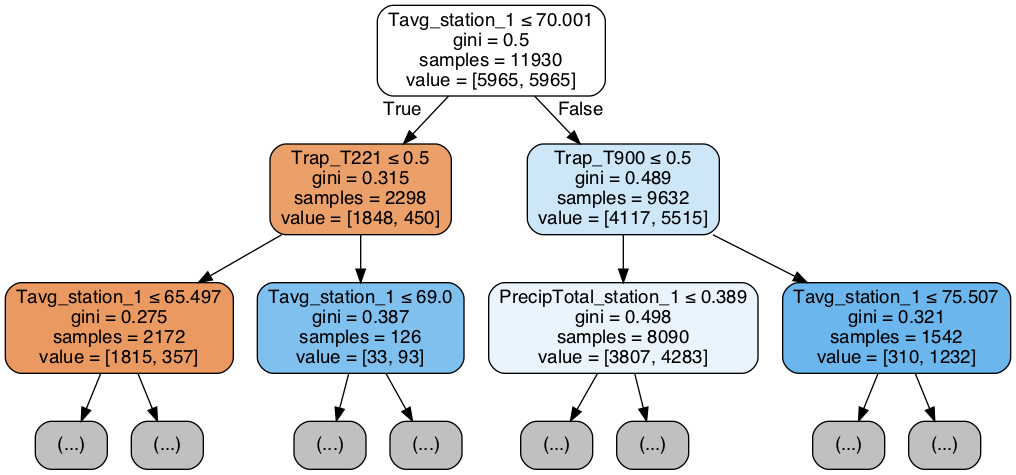

In [19]:
# Plot the Decision Tree:
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                max_depth=2,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X_train_res_dum.columns
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [20]:
feature_importance = pd.DataFrame(dt.feature_importances_,
                                  index=X_train_res_dum.columns,
                                  columns=['importance'])
feature_importance.sort_values('importance',ascending=False).head(10)

# our Decision Tree now predicts Wnv will occur in only 3 of the traps

,importance
Tavg_station_1,0.583843
PrecipTotal_station_1,0.235613
Trap_T900,0.126147
Trap_T221,0.052553
Trap_T225,0.001843
Trap_T102,0.000000
Trap_T103,0.000000
Trap_T107,0.000000
Trap_T114,0.000000
Trap_T115,0.000000


In [ ]:
# To do:
    # Fix tableau to show WnvPresent_sum in Tooltip (perhaps feed in a grouped-by csv)
    # Add Trap to model (which will require SMOTE with categorical variables) in order to reflect location too
# Charles:
    # Look at which species and where for WnvPresent. Also because night-spraying doesn't affect some species
    # Related to that: try to see why spraying was ineffective e.g. in 2011. Was this on different days? Or was
        # it even on same day and therefore could be affecting different mosquitos?